## Classification Performance of Aggregated Features

### Import Libraries

In [214]:
import pandas as pd
import numpy as np
import synapseclient as sc
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"axes.facecolor": ".9", 'grid.color': '.8'})
%matplotlib inline

In [198]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [47]:
data = pd.read_csv("cleaned_walk_features.tsv", sep = "\t").dropna()

In [62]:
feat_used = [feat for feat in data.columns 
             if ("createdOn" not in feat) 
             and ("window" not in feat) 
             and ("error" not in feat) 
             and ('nrecords' not in feat)
             and ("healthCode" not in feat) 
             and ("gender" not in feat) 
             and ("PD" not in feat) 
             and ("age" not in feat)]

In [63]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(data[feat_used],
                                                   data['PD'],
                                                   test_size = 0.25,
                                                   random_state = 100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2597, 106)
(866, 106)
(2597,)
(866,)


### Classifiers

In [200]:
clfs = []
clfs.append(LogisticRegression())
clfs.append(RidgeClassifier())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier(max_depth = 5, 
                                   random_state = 100, 
                                   n_estimators = 5000))
clfs.append(GradientBoostingClassifier(max_depth = 5, 
                                       random_state = 100, 
                                       n_estimators = 1000))

### Validation Set Performance (ROC-AUC)

In [201]:
model_metrics_placeholder = {}
model_metrics_placeholder["classifier"] = []
model_metrics_placeholder["cross_validation_auc_score"] = []
model_metrics_placeholder["cross_validation_std"] = []
model_metrics_placeholder["test_auc_score"] = []

In [202]:
for classifier in clfs:
    pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', classifier)])
    
    scores = cross_validate(pipeline, 
                            X_train, 
                            y_train,
                            cv = 10, 
                           scoring = "roc_auc")
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
    
    model_metrics_placeholder["classifier"].append(type(classifier).__name__)
    model_metrics_placeholder["cross_validation_auc_score"].append(scores["test_score"].mean())
    model_metrics_placeholder["cross_validation_std"].append(scores["test_score"].std())

---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.04722054004669189
fit_time  std  0.0066735865632215315
score_time  mean  0.0032083272933959963
score_time  std  0.00013531244972700987
test_score  mean  0.8079767773715657
test_score  std  0.036692834019000566
---------------------------------
RidgeClassifier()
-----------------------------------
fit_time  mean  0.014597487449645997
fit_time  std  0.0008552355189403533
score_time  mean  0.004298257827758789
score_time  std  0.00017042372168024923
test_score  mean  0.8076331144980677
test_score  std  0.033841451232582476
---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.35431780815124514
fit_time  std  0.007488450443425627
score_time  mean  0.03535773754119873
score_time  std  0.0010758382244706727
test_score  mean  0.8207411049719344
test_score  std  0.03141403844071745
---------------------------------
KNeighborsClassifier(n_neighbors

### Test-set Performance (ROC-AUC)

In [203]:
for classifier in clfs:
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', classifier)])
    auc_score = roc_auc_score(pipeline.fit(X_train, y_train).predict(X_test), y_test)
    print("ROC-AUC Score on Test-Set %s \n"%auc_score)
    model_metrics_placeholder["test_auc_score"].append(auc_score)

---------------------------------
LogisticRegression()
-----------------------------------
ROC-AUC Score on Test-Set 0.7573237597911227 

---------------------------------
RidgeClassifier()
-----------------------------------
ROC-AUC Score on Test-Set 0.7694422751529351 

---------------------------------
SVC()
-----------------------------------
ROC-AUC Score on Test-Set 0.8076655294854835 

---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
ROC-AUC Score on Test-Set 0.62514199935086 

---------------------------------
DecisionTreeClassifier()
-----------------------------------
ROC-AUC Score on Test-Set 0.6073957727360869 

---------------------------------
RandomForestClassifier(max_depth=5, n_estimators=5000, random_state=100)
-----------------------------------
ROC-AUC Score on Test-Set 0.8503665189226048 

---------------------------------
GradientBoostingClassifier(max_depth=5, n_estimators=1000, random_state=100)
----------

### Visualizing Prediction Probability (Random Forest)

In [232]:
pipeline = Pipeline([
        ('normalizer', MinMaxScaler()), 
        ('clf', clfs[5])])

In [ ]:
proba = pipeline.fit(X_train, y_train).predict_proba(X_test)
proba = pd.DataFrame(proba).rename({0:"Healthy Probability Score", 
                                    1:"PD Probability Score"}, axis = 1)
label = pd.DataFrame(y_test).reset_index(drop = True)
proba_df = pd.concat([proba, label], axis = 1)

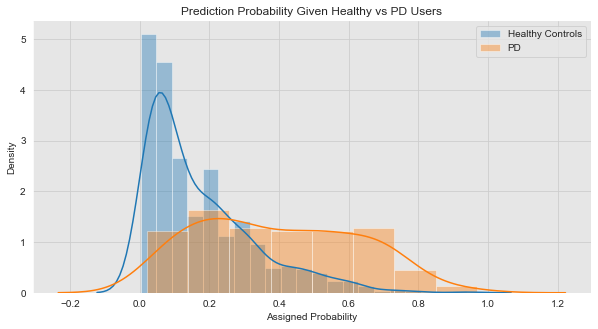

In [231]:
plt.figure(figsize = (10,5))
sns.distplot(proba_df[proba_df["PD"] == 0]["PD Probability Score"], label = "Healthy Controls")
sns.distplot(proba_df[proba_df["PD"] == 1]["PD Probability Score"], label = "PD")
sns.despine()

plt.title("Random Forest Prediction Probability Given Healthy vs PD Users")
plt.xlabel("Assigned Probability")
plt.ylabel("Density")
plt.legend()
plt.show()